# Topic Clustering using Sentence Embeddings

In [1]:
import os
import sys
PATH = '/home/piotr/projects/twitter'
PATH_DATA = os.path.join(PATH, 'data/clean/')
PATH_RESULTS = os.path.join(PATH, 'results/topics/kmeans')
PATH_EMBEDDINGS = '/home/piotr/nlp/cc.pl.300.vec'
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
sys.path.append(os.path.join(PATH, 'src'))
START = '2020_02_22' #start date (first file)
END = '2020_07_20' #end date (last file)
TRAIN_SIZE = 0.1

In [20]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import gc
import numpy as np
import pandas as pd
from itertools import chain, product
import re
import json
import matplotlib.pyplot as plt
from nltk import FreqDist, word_tokenize
import seaborn as sns
from tqdm.notebook import tqdm
from gensim.models import KeyedVectors
tqdm.pandas()
from twitter_models.embeddings import KTopicModel, KTopicModelCosine, DBSCANTopics
from twitter_tools.utils import read_files, batch
from twitter_tools import topic_evaluation
from sklearn.model_selection import StratifiedShuffleSplit
from functools import partial
import pdb
import gc
dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))

## Introduction
In this notebook, I evaluate Tweet topic clustering obtained through the method specified by Demszky et al. in accordance with the sentence embeddings method proposed by Arora et al. 2017. For each Tweet, its embedding was calculated as the weighted sum of its lemmatized tokens, where the weights where tokens' respective weights were inversly proportional to each token's probability of occurence, using a normalzing constant $a$, such that $w = \frac{a}{ap(w)}$ Clustering was done using Minibatch K Means clustering algorithm, using sample of 10% of the total unique tweets, stratified w.r.t the date and party alligiance, to ensure the representativeness of the results.

### Data loading
The data is loaded from the preprocessed files, additionally excluding the ids flagged as problematic by the analysis performed in the `preprocessing` notebook. The Tweets that included less than 50% of Polish vocabulary or were tagged as outliers are also removed. Below, I define a filter function which is used toegether with the data loader function `read_files` specified in the module `twitter_tools.utils`.

In [9]:
drop_users = json.load(open(os.path.join(PATH, 'results/cleaning/drop_users.json'), 'r'))
drop_tweets = json.load(open(os.path.join(PATH, 'results/cleaning/drop_tweets.json'), 'r'))
def filter_fun(df, drop_users, drop_tweets, drop_duplicates = True):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    if drop_duplicates:
        df.drop_duplicates(inplace = True)
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets)

In [4]:
data = pd.DataFrame()
for dat in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff, method = 'pandas')):
    dat.drop_duplicates(subset = ['lemmatized'], inplace = True)
    dat.lemmatized = dat.lemmatized.apply(lambda x: x.split())
    dat = dat.groupby('source').apply(lambda x: x.sample(frac = TRAIN_SIZE, random_state = 1234))
    data = data.append(dat)
    gc.collect()
data.drop_duplicates(subset = ['tokenized'], inplace = True)
text = data['lemmatized'].tolist()
data.reset_index(inplace = True, drop = True)
print(f'Data loadead. Train size {len(text)}')


Data loadead. Train size 547645


### Grid Search
To identify the optimal clustering hyperparameters (number of centroids `k` and the `a` inverse frequency weighting constant) I performed a grid search over a range of parameters, computing the silhuette score on 10% of the training data and obtaining the within-cluster sum of squares.

In [8]:
def grid_search(text:list, folder_results:str, path_embeddings:str):
    #set up grid:
    keys = params.keys(); combs = product(*params.values()) #keys + all combinations of parameters
    grid = [dict(zip(keys, elem)) for elem in combs] #zip these toegether into a list of dicts
    
    #iterate
    for i, param in tqdm(enumerate(grid)): 
        ktp = KTopicModel(k = param["k"], a = param["a"], path_embeddings = path_embeddings)
        
        #fit the model
        ktp.fit(text)
        #evaluate:
        grid[i]['silhuette'] = ktp.evaluate(text, sample_size = round(0.1 * len(text)))
        grid[i]['inertia'] = ktp.cluster.inertia_
        print(f'Done evaluating {i} out of {len(grid)}. \
        K: {grid[i]["k"]} \
        A: {grid[i]["a"]} \
        Silhuette score {round(grid[i]["silhuette"], 4)}. \
        Inertia {round(grid[i]["inertia"], 4)}')
        #save:
        pickle.dump(ktp, open(os.path.join(folder_results, f'cluster_k_{ktp.k}_a_{ktp.a}.p'), 'wb'))
        del ktp
        gc.collect()
    return grid

In [9]:
%%time
PATH_COMPARISON = os.path.join(PATH_RESULTS, 'grid_search.json')
if os.path.isfile(PATH_COMPARISON):
    results = json.load(open(PATH_COMPARISON, 'r'))
else:
    #run grid search:
    params = {'k':list(range(5, 20, 2)), 'a':[1, 1e-1, 1e-2, 1e-3], 'n_components':[0, 1, 2]}
    results = grid_search(data.lemmatized, PATH_RESULTS, PATH_EMBEDDINGS)
    json.dump(results, open(PATH_COMPARISON, 'w'))

Done evaluating 0 out of 15.         K: 15         A: 0.1         Silhuette score -0.0073.         Inertia 174009.1315
Done evaluating 1 out of 15.         K: 15         A: 0.01         Silhuette score -0.0194.         Inertia 154284.9962
Done evaluating 2 out of 15.         K: 15         A: 0.001         Silhuette score 0.0036.         Inertia 119695.5955
Done evaluating 3 out of 15.         K: 17         A: 0.1         Silhuette score -0.0176.         Inertia 168330.7164
Done evaluating 4 out of 15.         K: 17         A: 0.01         Silhuette score -0.0418.         Inertia 146072.6852
Done evaluating 5 out of 15.         K: 17         A: 0.001         Silhuette score 0.1167.         Inertia 119325.0216
Done evaluating 6 out of 15.         K: 19         A: 0.1         Silhuette score -0.0007.         Inertia 170050.1411
Done evaluating 7 out of 15.         K: 19         A: 0.01         Silhuette score 0.0011.         Inertia 152883.8644
Done evaluating 8 out of 15.         K: 19  

### Evaluation methods:
The models were compared on the following criteria:

**1. Measures of clustering fit - silhuette score computed by bootstrapping and within-cluster sum of squares**

a
0.001    AxesSubplot(0.125,0.125;0.775x0.755)
0.010    AxesSubplot(0.125,0.125;0.775x0.755)
0.100    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

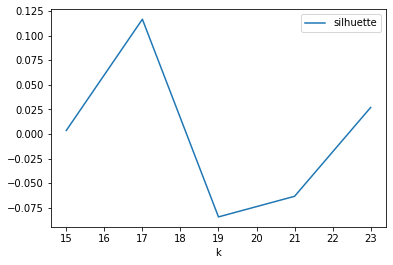

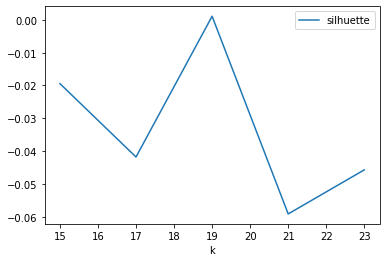

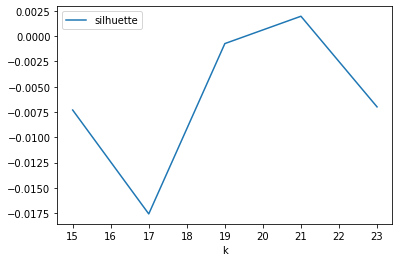

In [11]:
results = pd.DataFrame(json.load(open(PATH_COMPARISON, 'r')))
results.groupby('a').plot('k','silhuette')

a
0.001    AxesSubplot(0.125,0.125;0.775x0.755)
0.010    AxesSubplot(0.125,0.125;0.775x0.755)
0.100    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

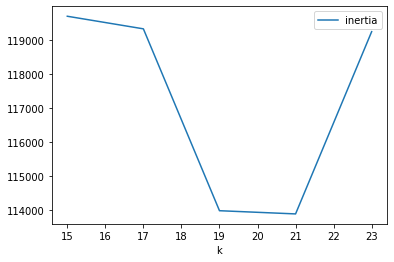

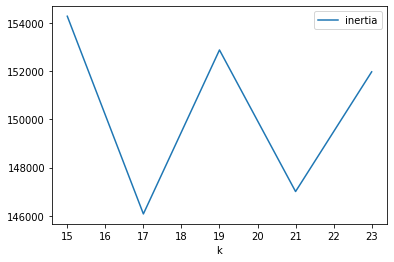

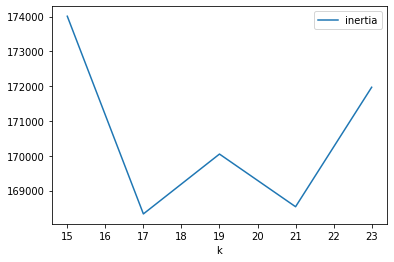

In [12]:
results = pd.DataFrame(json.load(open(PATH_COMPARISON, 'r')))
results.groupby('a').plot('k','inertia')

**2. Closest word vectors to cluster centroids**

In [3]:
fasttext = KeyedVectors.load_word2vec_format('/home/piotr/nlp/cc.pl.300.vec')

**3. Most common tokens in each cluster that didn't occur in the most common words of other clusters**

**4. Topic distribution**
 - overall
 - between parties
 - temporal

### K = 5 a = 0.0001

In [11]:
path_model = os.path.join(PATH, 'results/topics/kmeans/cluster_k_17_a_0.001.p')

In [12]:
ktp = pickle.load(open(path_model, 'rb'))

2. **Closest words for cluster centroids**

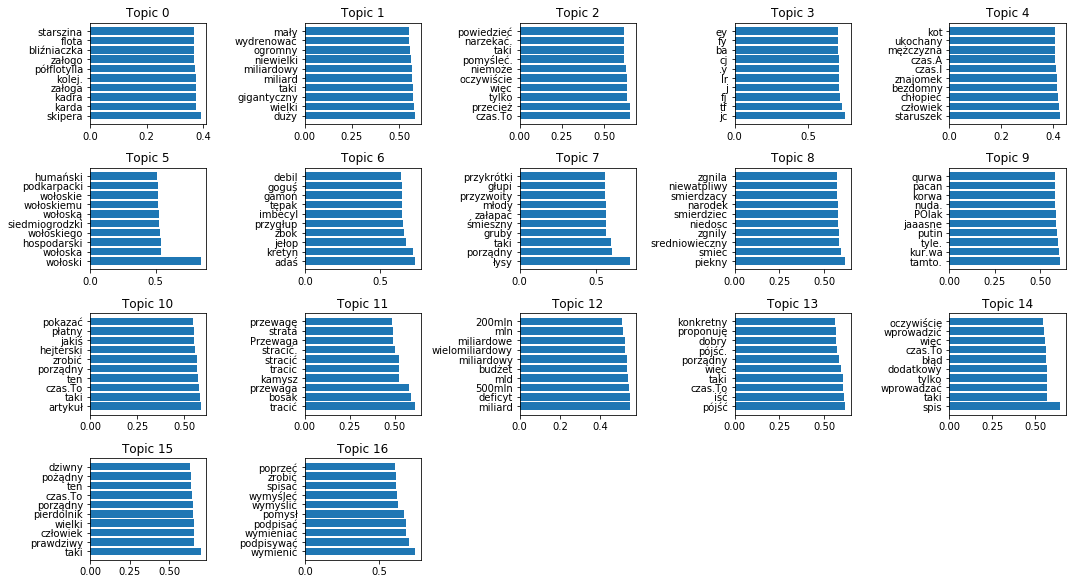

In [30]:
topic_evaluation.plot_n_closest(ktp, fasttext, topn = 10)

**3. Most common unique tokens**

In [17]:
data = next(read_files(PATH_DATA, day_from = "2020_04_20", day_to = "2020_04_21", dtype = dtypes, filter_fun = ff, method = 'pandas')).sample(frac = 0.4)
data['lemmatized'] = data['lemmatized'].apply(lambda x: [w for w in x.split() if w not in stopwords])
_ = topic_evaluation.plot_kmeans_centroids(ktp, data['lemmatized'], fasttext, output = 'kmeans.html', topn = 10)

Plot(id='1193', ...)

In [ ]:
#get predictions of topics
path_topics = path_model.replace('.p', '.json')
if os.path.isfile(path_topics):
    cls = json.load(open(os.path.join(path_topics),'r'))
else:
    cls = predict_clusters(ktp, data['lemmatized'].astype(str), batch_size = 100000)
    json.dump(cls, open(os.path.join(path_topics),'w'))

In [ ]:
#get best match for each id
cls = {k:sorted(v.items(), key = lambda x: x[1], reverse = True)[0][0] for k, v in cls.items()}
data = topic_evaluation.map_clusters(data, cls)

In [ ]:
df, dists = topic_evaluation.clustering_summary(data.lemmatized.astype(str).apply(lambda x: x.split()), 
                          data.cluster.astype(int),
                       data.source)
df

In [ ]:
topic_evaluation.plot_words(dists, figsize = (10, 10))

**4. Distributions**

In [ ]:
topic_evaluation.plot_dists(data, figsize = (14, 10))